#Assignment 2: NN Model on Solubility#
##### Aidan Holland, Machine Learning and Molecules #####

The goal of this assignment is to use neural networks to create a model that can efficiently predict the solubility of molecules based upon their structure. We are unable to use the structure to predict the solubility without convolution, and thus we use fingerprint bit vector to binarily represent a molecule. This allows us to easily process our molecules into a predictive formula.

##Data Source and Imported Functions##

In [2]:
%%capture
!pip install rdkit
!pip install mols2grid

NameError: ignored

In [ ]:
%%bash
wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2023-06-08 19:19:46--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv.7’

     0K .......... .......... .......... .......... .......... 52% 49.4M 0s
    50K .......... .......... .......... .......... ....      100% 66.9M=0.002s

2023-06-08 19:19:46 (56.3 MB/s) - ‘delaney-processed.csv.7’ saved [96699/96699]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole

##Code##

In [ ]:
# isolating only important data
data = pd.read_csv('delaney-processed.csv')
data = data[["measured log solubility in mols per litre", "smiles"]]

# smiles data -> fingerprints
def SmilesToFPS(smiles):
  mol = Chem.MolFromSmiles(smiles)
  fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
  fps = np.array(fps)
  return fps

# splitting data
train, test = train_test_split(data, test_size = 0.05, random_state = 50)
y_train = train["measured log solubility in mols per litre"]
y_test = test["measured log solubility in mols per litre"]
X_train = np.array([SmilesToFPS(smiles) for smiles in train.smiles])
X_test = np.array([SmilesToFPS(smiles) for smiles in test.smiles])

# neural network model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dense(128, activation='relu'),
    Dense(1, activation = 'linear'),
])

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer ='adam',
    loss = 'mean_squared_error',
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
)

# error calculation
y_test_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE =",rmse_test)

Epoch 1/30
14/14 [==============================] - 1s 16ms/step - loss: 7.3096 - val_loss: 4.6289
Epoch 2/30
14/14 [==============================] - 0s 7ms/step - loss: 3.1253 - val_loss: 2.5780
Epoch 3/30
14/14 [==============================] - 0s 7ms/step - loss: 1.8120 - val_loss: 2.0081
Epoch 4/30
14/14 [==============================] - 0s 8ms/step - loss: 1.2209 - val_loss: 1.7531
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 0.9424 - val_loss: 1.7015
Epoch 6/30
14/14 [==============================] - 0s 7ms/step - loss: 0.7139 - val_loss: 1.6684
Epoch 7/30
14/14 [==============================] - 0s 6ms/step - loss: 0.5562 - val_loss: 1.6310
Epoch 8/30
14/14 [==============================] - 0s 8ms/step - loss: 0.4339 - val_loss: 1.6166
Epoch 9/30
14/14 [==============================] - 0s 7ms/step - loss: 0.3401 - val_loss: 1.6002
Epoch 10/30
14/14 [==============================] - 0s 6ms/step - loss: 0.2685 - val_loss: 1.5841
Epoch 11/30
14/14 

34/34 [==============================] - 0s 3ms/step


Text(0, 0.5, 'Predicted Solubility')

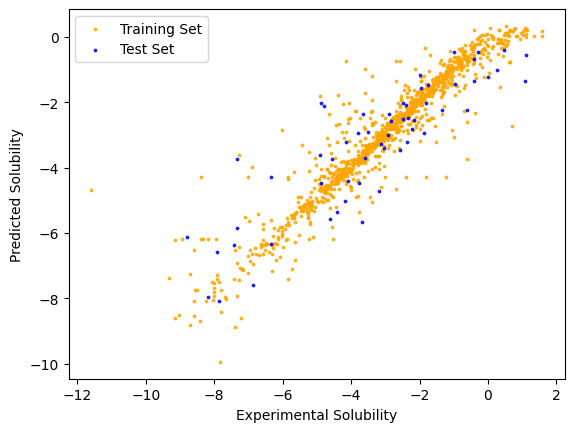

In [ ]:
# evaluation of model and scatterplot
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
plt.scatter(y_train, y_train_pred, label="Training Set", color = 'orange', alpha = 0.8, s=3)
plt.scatter(y_test, y_test_pred, label="Test Set", color = 'blue', alpha = 0.8, s=3)
plt.legend()
plt.xlabel("Experimental Solubility")
plt.ylabel("Predicted Solubility")

# horizontal lines at around in the training set at y = -3.5, -4, -5.3

In [ ]:
test["y_pred"] = y_test_pred
train["y_pred"] = y_train_pred
y_train_pred_dups = train[train.duplicated(subset = "y_pred", keep = False)]
y_train_pred_dups.sort_values(by="y_pred")

,measured log solubility in mols per litre,smiles,y_pred
3,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.483359
52,-8.057,c1ccc2c(c1)ccc3c4ccccc4ccc23,-7.483359
450,-7.200,ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2,-7.103908
1019,-7.200,ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2,-7.103908
167,-6.523,O=C1N(COC(=O)CCCCCCC)C(=O)C(N1)(c2ccccc2)c3ccccc3,-6.352258
...,...,...,...
703,-1.220,Cc1ncc(N(=O)=O)n1CCO,-1.208006
309,-1.290,OC1CCCCCCC1,-0.836899
409,-0.880,OC1CCCCCC1,-0.836899
356,0.320,C/C=C/C=O,0.209948


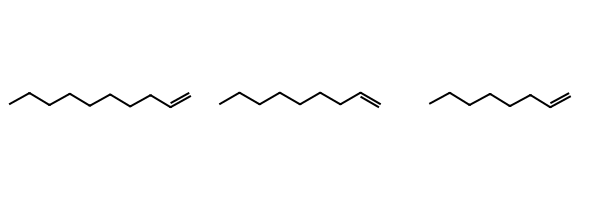

In [ ]:
dup_check = y_train_pred_dups[y_train_pred_dups.y_pred == y_train_pred_dups.loc[124, "y_pred"]]
dup_check_mols = [Chem.MolFromSmiles(smiles) for smiles in dup_check.smiles]
dup_check_mols_img = Draw.MolsToGridImage(dup_check_mols)
info = {}
dup_check_mols_fps = rdMolDescriptors.GetMorganFingerprintAsBitVect(dup_check_mols[0], 2, bitInfo = info)
tpls = [(dup_check_mols[0], x, info) for x in dup_check_mols_fps.GetOnBits()]
dup_check_mols_img

Given these images, it is very clear as to why the fingerprint bit vectors as our X input would provide identical predicted solubility values. Their structures are extremely similar.

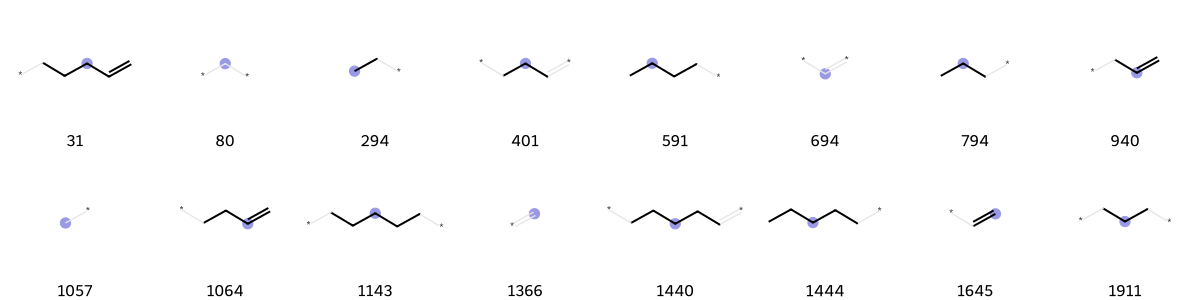

In [ ]:
Draw.DrawMorganBits(tpls, molsPerRow=8, legends=[str(x) for x in dup_check_mols_fps.GetOnBits()])

In [3]:
print("Average Solubility =",np.mean(y_test))
print("Standard Deviation =",np.std(y_test))
print("Root Mean Squared Error =",np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

y_test_pred_flat = y_test_pred.flatten()
root_squared_error = np.sqrt((y_test_pred_flat - y_test)**2)
correlation = np.corrcoef(y_test, root_squared_error)[0,1]
print("Correlation=",correlation)

NameError: ignored

##Results##

Standard deviation (SD) and root mean squared error (RMSE) are good to compare because SD is a measure of the data's spread around the mean, while RMSE measures the difference between our model's predicted values and the actual values. Both clue us into variability.

The correlation between the error and the solubility is weak and negative at around -0.22. This implies that error decreases with higher solubility, meaning that the model is probably a little bit worse at predicting molecules with lower solubility, given that the error will increase. However, the closeness to 0 of the value implies that it is an unreliable trend.

Our test RMSE result would be described as not sensitive to test splits. Increasing test percentage incrementally by 5, from 5 to 45, yielded results that range between 1.2 and 1.35, with all other hyperparameters essentially optimized.